In [231]:
from __future__ import division, print_function, absolute_import

import tmm
import math
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

from enum import Enum
from typing import NamedTuple

from tmm_fast import coh_tmm

In [232]:
parameters_t = np.dtype([
    ("f_k", "f4"),
    ("n_k", "f4"),
    ("f_m", "f4"),
    ("n_m", "f4"),
    ("k_m", "c8"),
    ("f_a", "f4"),
    ("n_a", "f4"),
])

In [233]:
class Material(Enum):
    KERATIN = 1
    MELANIN_MEMBRANE = 2
    MELANIN_INTERNAL = 3
    AIR = 4

In [234]:
def cauchy(A, B, wavelengths):
    return A + B*wavelengths**-2

def melanin_imaginary(wavelengths):
    a_m = 0.56
    b_m = 270
    return a_m * np.exp(-wavelengths / b_m) * 1.0j

def keratin_index(wavelengths):
    A_k = 1.532
    B_k = 5890
    return cauchy(A_k, B_k, wavelengths)

def melanin_index(wavelengths):
    A_m = 1.648
    B_m = 23700
    return cauchy(A_m, B_m, wavelengths)

In [235]:
def calc_keratin_layer(wavelengths):
    parameters = np.zeros(wavelengths.shape, dtype=parameters_t)
    parameters["f_k"] = 1
    parameters["n_k"] = keratin_index(wavelengths)
    parameters["f_m"] = 0
    parameters["n_m"] = 0
    parameters["k_m"] = 0
    parameters["f_a"] = 0
    parameters["n_a"] = 0
    return parameters

In [236]:
def calc_melanin_layer(wavelengths):
    parameters = np.zeros(wavelengths.shape, dtype=parameters_t)
    parameters["f_k"] = 0
    parameters["n_k"] = 0
    parameters["f_m"] = 1
    parameters["n_m"] = melanin_index(wavelengths)
    parameters["k_m"] = melanin_imaginary(wavelengths)
    parameters["f_a"] = 0
    parameters["n_a"] = 0
    return parameters

In [237]:
def calc_melanosome_internal_layer_index(wavelengths):
    parameters = np.zeros(wavelengths.shape, dtype=parameters_t)
    parameters["f_k"] = 0.05
    parameters["n_k"] = keratin_index(wavelengths)
    parameters["f_m"] = 0.4
    parameters["n_m"] = melanin_index(wavelengths)
    parameters["k_m"] = melanin_imaginary(wavelengths)
    parameters["f_a"] = 0.55
    parameters["n_a"] = 1
    return parameters

In [238]:
def calc_refractive_index(parameters):
    n_eff = (
        parameters["f_k"] * parameters["n_k"]
        + parameters["f_m"] * (parameters["n_m"] + parameters["k_m"])
        + parameters["f_a"] * parameters["n_a"]
    )

    return n_eff

In [239]:
def calc_layers(wavelengths):
    # Thicknesses in nm
    keratin_cortex_thickness = 5 # c
    keratin_separation_thickness = 50 # d
    melanosome_membrane_thickness = 30 # a
    # Note: this can be changed to adjust periodicity

    # Default
    melanosome_internal_thickness = 100 # b2
    top_melanosome_internal_thickness = 50 # b1

    # Fig. 8d
    # melanosome_internal_thickness = 110 # b2
    # top_melanosome_internal_thickness = 25 # b1

    air_layer_indices = np.ones(wavelengths.shape)
    keratin_layer_indices = calc_refractive_index(calc_keratin_layer(wavelengths))
    melanosome_membrane_indices = calc_refractive_index(calc_melanin_layer(wavelengths))
    melanosome_internal_indices = calc_refractive_index(calc_melanosome_internal_layer_index(wavelengths))

    # Init layers to first infinite air layer
    layers = [[Material.AIR, np.inf]]

    # Add keratin cortex layer
    layers.append([Material.KERATIN, keratin_cortex_thickness])

    # Add top melanosome layer
    layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])
    layers.append([Material.MELANIN_INTERNAL, top_melanosome_internal_thickness])
    layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])

    # Add the rest of the keratin separation and melanosome layers
    melanosome_layers = 12
    melanosome_layers -= 1  # Because of the top melanosome layer
    for _ in range(melanosome_layers):
        layers.append([Material.KERATIN, keratin_separation_thickness])
        layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])
        layers.append([Material.MELANIN_INTERNAL, melanosome_internal_thickness])
        layers.append([Material.MELANIN_MEMBRANE, melanosome_membrane_thickness])

    # Add keratin cortex layer
    layers.append([Material.KERATIN, keratin_cortex_thickness])

    # Add last infinite air layer
    layers.append([Material.AIR, np.inf])

    layers = np.array(layers)

    layers_indices = np.empty((layers.shape[0], wavelengths.size), dtype=np.complex64)
    layers_indices[layers[:, 0] == Material.AIR] = air_layer_indices
    layers_indices[layers[:, 0] == Material.KERATIN] = keratin_layer_indices
    layers_indices[layers[:, 0] == Material.MELANIN_MEMBRANE] = melanosome_membrane_indices
    layers_indices[layers[:, 0] == Material.MELANIN_INTERNAL] = melanosome_internal_indices

    return layers[:, 1], layers_indices

[1.4620e-03 4.6600e-04 1.3866e-02 1.0000e+00]
[0.232077 0.059889 0.437695 1.      ]
[0.550287 0.161158 0.505719 1.      ]
[0.868793 0.287728 0.409303 1.      ]
[0.994738 0.62435  0.427397 1.      ]


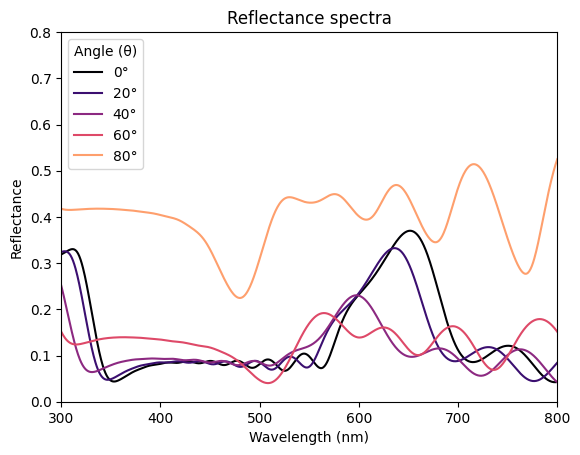

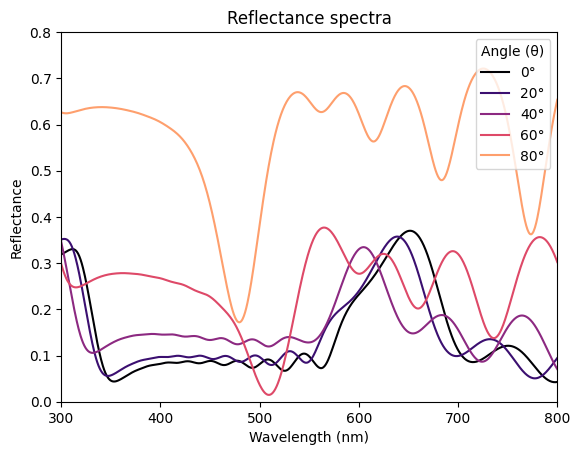

In [240]:
wavelengths = np.linspace(300, 800, 800)
thetas = np.deg2rad(np.arange(0, 90, 20))

d_list, n_list = calc_layers(wavelengths)

d_list = np.expand_dims(d_list, axis=0).astype(np.float32)
n_list = np.expand_dims(n_list, axis=0)

polarization = "s"
Os = coh_tmm(polarization, n_list, d_list, thetas, wavelengths, device="cpu")
Op = coh_tmm("p", n_list, d_list, thetas, wavelengths, device="cpu")

cmap = plt.get_cmap('magma')
# Use only 0 to 0.8 of the color map to avoid the lightest colors
colors = cmap(np.linspace(0, 1, len(thetas) + 1))

plt.figure()
for i, theta in enumerate(thetas):
    avg = 0.5 * (Os["R"][0, i, :] + Op["R"][0, i, :])
    print(colors[i])
    plt.plot(wavelengths, avg, label=f'{np.rad2deg(theta):.0f}°', color=colors[i])

plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.xlim(300, 800)
plt.ylim(0, 0.8)
plt.title("Reflectance spectra")
plt.legend(title='Angle (θ)')

plt.figure()
for i, theta in enumerate(thetas):
    plt.plot(wavelengths, Os["R"][0, i, :], label=f'{np.rad2deg(theta):.0f}°', color=colors[i])

plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.xlim(300, 800)
plt.ylim(0, 0.8)
plt.title("Reflectance spectra")
plt.legend(title='Angle (θ)')